In [ ]:
# In this mini project, we will deal with time series, and we will learn to
# predict one variable as a function of other variables within the time series.
# We will use Recurrent Neural Networks (RNN's) to do so.

In [ ]:
# Example takend and adapted from:
# https://towardsdatascience.com/predicting-stock-price-with-lstm-13af86a74944
# Data from: https://www.kaggle.com/darkknight91/ge-stock
# 55 years of stock price data for GE for US

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Parte 1: Carga y limpia los datos

In [ ]:
# Requiered to select a file to be imported into colab
from google.colab import files
uploaded = files.upload()

Saving ge.us.txt to ge.us (1).txt


In [ ]:
# Load file from colab (G drive)
df = pd.read_csv('ge.us.txt')
df.dropna(inplace=True)
df

,Date,Open,High,Low,Close,Volume,OpenInt
0,1962-01-02,0.6277,0.6362,0.6201,0.6201,2575579,0
1,1962-01-03,0.6201,0.6201,0.6122,0.6201,1764749,0
2,1962-01-04,0.6201,0.6201,0.6037,0.6122,2194010,0
3,1962-01-05,0.6122,0.6122,0.5798,0.5957,3255244,0
4,1962-01-08,0.5957,0.5957,0.5716,0.5957,3696430,0
...,...,...,...,...,...,...,...
14053,2017-11-06,20.5200,20.5300,20.0800,20.1300,60641787,0
14054,2017-11-07,20.1700,20.2500,20.1200,20.2100,41622851,0
14055,2017-11-08,20.2100,20.3200,20.0700,20.1200,39672190,0
14056,2017-11-09,20.0400,20.0710,19.8500,19.9900,50831779,0


In [ ]:
# Checking for NaN values.
print("checking if any null values are present\n", df.isna().sum())

checking if any null values are present
 Date       0
Open       0
High       0
Low        0
Close      0
Volume     0
OpenInt    0
dtype: int64


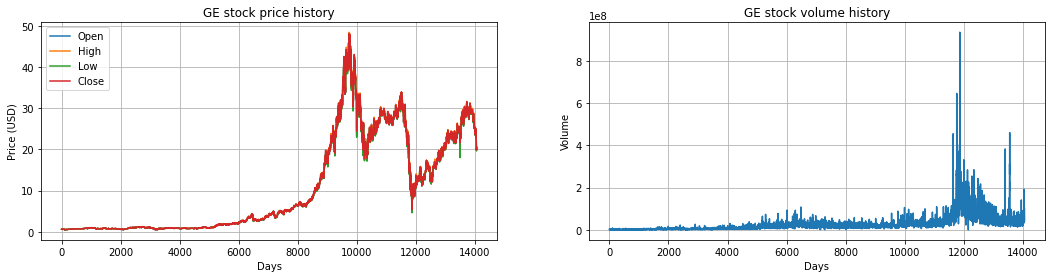

In [ ]:
# Plot info
plt.figure(figsize=(18, 4))
plt.subplot(1, 2, 1)
plt.plot(df["Open"])
plt.plot(df["High"])
plt.plot(df["Low"])
plt.plot(df["Close"])
plt.title('GE stock price history')
plt.ylabel('Price (USD)')
plt.xlabel('Days')
plt.legend(['Open','High','Low','Close'], loc='upper left')
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(df["Volume"])
plt.title('GE stock volume history')
plt.ylabel('Volume')
plt.xlabel('Days')
plt.grid()
plt.show()

In [ ]:
# Split train and test sets
df_train, df_test = train_test_split(df, train_size=0.8, test_size=0.2, shuffle=False)
print("Train and Test size", len(df_train), "--", len(df_test))
# Still in DataFrame format
# Notice the use of shuffle=False

Train and Test size 11246 -- 2812


In [ ]:
# Scale features and put them in matrix format (DataFrame --> Matrix)
useful_cols = ["Open", "High", "Low", "Close", "Volume"]

min_max_scaler = MinMaxScaler()
train_data = min_max_scaler.fit_transform(df_train.loc[:, useful_cols].values)
test_data = min_max_scaler.transform(df_test.loc[:, useful_cols].values)

# Here we have two sets. One with 11246 timesteps, each of 5 features, and other
# with 2812 timesteps, each of 5 features
print(train_data.shape)
print(test_data.shape)

(11246, 5)
(2812, 5)


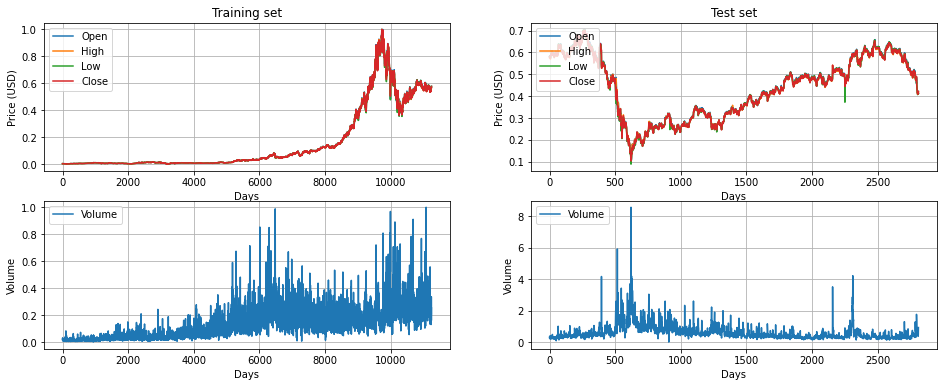

In [ ]:
# Plot time series
plt.figure(figsize=(16, 6))

plt.subplot(2, 2, 1)
plt.plot(train_data[:, :-1])
plt.title('Training set')
plt.ylabel('Price (USD)')
plt.xlabel('Days')
plt.legend(['Open','High','Low','Close'], loc='upper left')
plt.grid()

plt.subplot(2, 2, 2)
plt.plot(test_data[:, :-1])
plt.title('Test set')
plt.ylabel('Price (USD)')
plt.xlabel('Days')
plt.legend(['Open','High','Low','Close'], loc='upper left')
plt.grid()

plt.subplot(2, 2, 3)
plt.plot(train_data[:, -1])
plt.ylabel('Volume')
plt.xlabel('Days')
plt.legend(['Volume'], loc='upper left')
plt.grid()

plt.subplot(2, 2, 4)
plt.plot(test_data[:, -1])
plt.ylabel('Volume')
plt.xlabel('Days')
plt.legend(['Volume'], loc='upper left')
plt.grid()

plt.show()

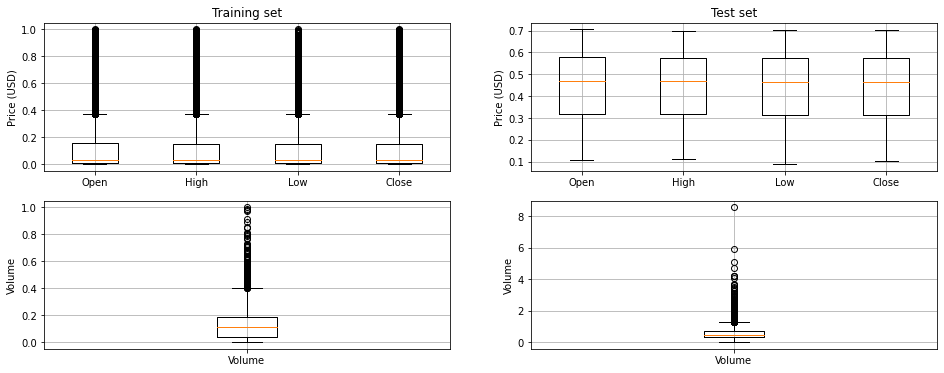

In [ ]:
# Plot distribution of variables
plt.figure(figsize=(16, 6))

plt.subplot(2, 2, 1)
plt.boxplot(train_data[:, :-1])
plt.title('Training set')
plt.ylabel('Price (USD)')
plt.xticks(ticks=range(1, 5), labels=['Open','High','Low','Close'])
plt.grid()

plt.subplot(2, 2, 2)
plt.boxplot(test_data[:, :-1])
plt.title('Test set')
plt.ylabel('Price (USD)')
plt.xticks(ticks=range(1, 5), labels=['Open','High','Low','Close'])
plt.grid()

plt.subplot(2, 2, 3)
plt.boxplot(train_data[:, -1])
plt.ylabel('Volume')
plt.xticks(ticks=range(1, 2), labels=['Volume'])
plt.grid()

plt.subplot(2, 2, 4)
plt.boxplot(test_data[:, -1])
plt.ylabel('Volume')
plt.xticks(ticks=range(1, 2), labels=['Volume'])
plt.grid()

plt.show()

# Parte 2: Formatea los datos para procesarlos con RNNs

In [ ]:
# GOAL:
# Predict 'close' value, from 4 historic timesteps,
# y[t] = f(x[t-1], x[t-2], x[t-3], x[t-4]; \Omega),
# where x[t] = [open, high, low, close, volume][t],
# and y[t] = [close][t]

In [ ]:
# AUX funtion to build time-series dataset
def build_dataset(X, Y, hist_size):
  '''
  Params
    X: data matrix [n_time_steps, n_X_feats]
    Y: label matrix [n_time_steps, n_Y_feats]
    hist_size: integer indicating the number of time steps in each sample of x
  Returns
    x: tensor of input data [n_samples, n_timesteps, n_X_features]
    y: tensor of output data [n_samples, n_Y_features]
  '''
  n_samples = Y.shape[0] - hist_size
  x = np.zeros((n_samples, hist_size, X.shape[1]))
  y = np.zeros((n_samples))

  for ind in range(n_samples):    
    x[ind] = X[ind : ind + hist_size]
    y[ind] = Y[ind + hist_size]
  return x, y

In [ ]:
# Create time-series datasets: Use all features as input, and 'close' as output.
time_steps = 4
x_train, y_train = build_dataset(train_data, train_data[:, 3], time_steps)
x_test,  y_test  = build_dataset(test_data,  test_data[:, 3],  time_steps)

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(11242, 4, 5)
(2808, 4, 5)
(11242,)
(2808,)


In [ ]:
# Print some examples
print("Original first 10 elements")
print(train_data[:10])
print("\nTime-series format of first 4 elements x")
print(x_train[:4])
print("\nTime-series format of first 4 elements y")
print(y_train[:4])

Original first 10 elements
[[0.00356678 0.00352766 0.00358385 0.00338425 0.02108267]
 [0.00340607 0.00319219 0.00341628 0.00338425 0.01365459]
 [0.00340607 0.00319219 0.00323598 0.00321827 0.01758709]
 [0.00323903 0.00302758 0.00272904 0.00287161 0.02730914]
 [0.00289013 0.00268378 0.0025551  0.00287161 0.03135089]
 [0.00289013 0.00285047 0.00289873 0.00287161 0.02293968]
 [0.00289013 0.00285047 0.00306629 0.00287161 0.01889791]
 [0.00289013 0.00268378 0.00289873 0.00287161 0.01529311]
 [0.00289013 0.00285047 0.00289873 0.00270563 0.01594855]
 [0.00289013 0.00268378 0.00306629 0.00287161 0.02064569]]

Time-series format of first 4 elements x
[[[0.00356678 0.00352766 0.00358385 0.00338425 0.02108267]
  [0.00340607 0.00319219 0.00341628 0.00338425 0.01365459]
  [0.00340607 0.00319219 0.00323598 0.00321827 0.01758709]
  [0.00323903 0.00302758 0.00272904 0.00287161 0.02730914]]

 [[0.00340607 0.00319219 0.00341628 0.00338425 0.01365459]
  [0.00340607 0.00319219 0.00323598 0.00321827 0.0175

# Parte 3: Crea la RNN y entrenala

In [ ]:
  from tensorflow.keras.models import Sequential
  from tensorflow.keras.layers import Input, Dropout, SimpleRNN, LSTM, Dense, LeakyReLU
  from tensorflow.keras.utils import plot_model

In [ ]:
# Create RNN model
rnn_model = Sequential()
rnn_model.add(Input(shape=(x_train.shape[1], x_train.shape[2])))
rnn_model.add(SimpleRNN(units=32))
rnn_model.add(Dense(1, activation='sigmoid'))

rnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 32)                1216      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 1,249
Trainable params: 1,249
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Compile
rnn_model.compile(loss='mean_squared_error', optimizer='rmsprop')

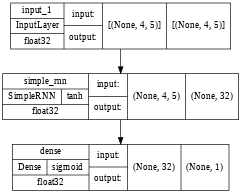

In [ ]:
# Plot model
plot_model(rnn_model, show_shapes=True, show_dtype=True, show_layer_names=True,
           dpi=48, show_layer_activations=True)

In [ ]:
# == Q1 ==
# ¿Qué activaciones no lineales usa RNN por defecto?
# ¿Qué activaciones no lineales usa LSTM por defecto?
# ¿Por qué uso la activación 'sigmoide' a la salida de la red?

In [ ]:
# Weights in the first layer (simpleRNN, Input does not count as layer)
B, A, C = rnn_model.layers[0].get_weights()
print(Wx.shape)
print(Wh.shape)
print(b.shape)

# == Q2 == 
# Renombra las variables A, B, C, usando la notación vista en clase: W(h), W(x), etc...

(5, 32)
(32, 32)
(32,)


In [ ]:
# Weights in the second layer (FullyConnected)
W, b = rnn_model.layers[1].get_weights()
print(W.shape)
print(b.shape)

(32, 1)
(1,)


In [ ]:
# Train
rnn_model.fit(x_train, y_train, batch_size=32, epochs=10, validation_split=0.1)

Epoch 1/10
317/317 [==============================] - 4s 6ms/step - loss: 0.0128 - val_loss: 0.0121
Epoch 2/10
317/317 [==============================] - 1s 3ms/step - loss: 4.7374e-04 - val_loss: 5.8709e-04
Epoch 3/10
317/317 [==============================] - 1s 3ms/step - loss: 2.5605e-04 - val_loss: 0.0024
Epoch 4/10
317/317 [==============================] - 1s 3ms/step - loss: 2.0766e-04 - val_loss: 0.0038
Epoch 5/10
317/317 [==============================] - 1s 3ms/step - loss: 1.8786e-04 - val_loss: 6.2982e-04
Epoch 6/10
317/317 [==============================] - 1s 2ms/step - loss: 1.5325e-04 - val_loss: 0.0073
Epoch 7/10
317/317 [==============================] - 1s 3ms/step - loss: 1.4556e-04 - val_loss: 0.0085
Epoch 8/10
317/317 [==============================] - 1s 2ms/step - loss: 1.4999e-04 - val_loss: 0.0013
Epoch 9/10
317/317 [==============================] - 1s 2ms/step - loss: 1.3863e-04 - val_loss: 3.0769e-04
Epoch 10/10
317/317 [==============================] - 1

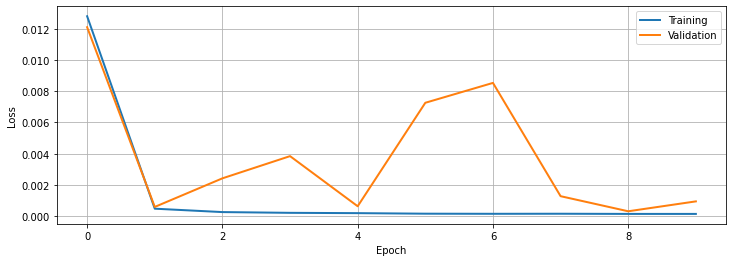

In [ ]:
# Plot loss
plt.figure(figsize=(12, 4))
plt.plot(rnn_model.history.history['loss'], label='Training', linewidth=2)
plt.plot(rnn_model.history.history['val_loss'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [ ]:
# Predict on training and test sets
y_train_hat = rnn_model.predict(x_train)
y_test_hat = rnn_model.predict(x_test)
print(y_train_hat.shape)
print(y_test_hat.shape)

(11242, 1)
(2808, 1)


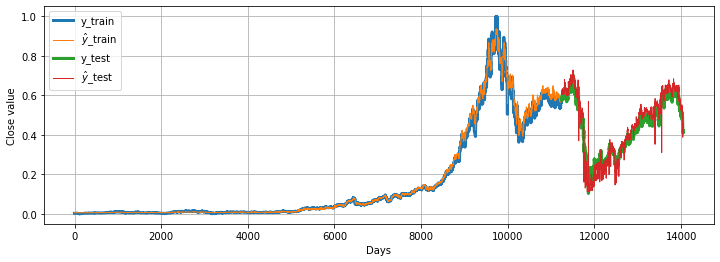

In [ ]:
# Plot y_train, y_train_hat, y_test and y_test_hat
x_ticks = np.arange(len(y_train) + len(y_test)) # Para poder imprimir test delante de train

plt.figure(figsize=(12, 4))
plt.plot(x_ticks[:len(y_train)], y_train, linewidth=3)
plt.plot(x_ticks[:len(y_train)], y_train_hat, linewidth=1)
plt.plot(x_ticks[len(y_train):], y_test, linewidth=3)
plt.plot(x_ticks[len(y_train):], y_test_hat, linewidth=1)
plt.ylabel('Close value')
plt.xlabel('Days')
plt.legend(['y_train', '$\hat{y}$_train', 'y_test', '$\hat{y}$_test'], loc='upper left')
plt.grid()
plt.show()

In [ ]:
# Let's go back to the original scale
# == Q3 ==
# ¿Qué está sucediendo en esta celda?
y_train_back = y_train * min_max_scaler.data_range_[3] + min_max_scaler.data_min_[3]
y_test_back = y_test * min_max_scaler.data_range_[3] + min_max_scaler.data_min_[3]

y_train_hat_back = y_train_hat * min_max_scaler.data_range_[3] + min_max_scaler.data_min_[3]
y_test_hat_back = y_test_hat * min_max_scaler.data_range_[3] + min_max_scaler.data_min_[3]

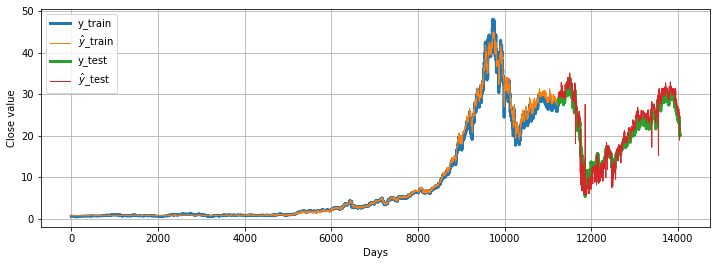

In [ ]:
# Plot y_train, y_train_hat, y_test and y_test_hat
x_ticks = np.arange(len(y_train) + len(y_test)) # Para poder imprimir test delante de train

plt.figure(figsize=(12, 4))
plt.plot(x_ticks[:len(y_train)], y_train_back, linewidth=3)
plt.plot(x_ticks[:len(y_train)], y_train_hat_back, linewidth=1)
plt.plot(x_ticks[len(y_train):], y_test_back, linewidth=3)
plt.plot(x_ticks[len(y_train):], y_test_hat_back, linewidth=1)
plt.ylabel('Close value')
plt.xlabel('Days')
plt.legend(['y_train', '$\hat{y}$_train', 'y_test', '$\hat{y}$_test'], loc='upper left')
plt.grid()
plt.show()

In [ ]:
# == Q4 ==
# Revisa la documentación de tensorflow para las capas simpleRNN y LSTM.
# ¿Qué sucede definimos el parámetro return_sequence=True?
# ¿Para qué sirve el parámetro return_state?

# Parte 4: Predice con "delay"

In [ ]:
# Crea una función "delayed_dataset" que formatee los datos para asociar y[t] con
# x[t-delay] hasta x[t-delay-history]. Por ejemplo, para hacer prónosticos del tipo
# y[10] = f(x[7], x[6], x[5]; \Omega). Donde tanto x como y pueden ser univariados
# o multivariados.
#
# For instance, calling such a function with the 
# x_train, y_train = delayed_dataset(X_train[:20, :3], X_train[:20, 3:], delay=2, hist=4)
# must return x_train and y_train with the following shapes,
# x_train.shape = (14, 4, 3) # 14 samples, each of 4 time-steps, each of 3 features
# y_train.shape = (14, 2)    # 14 label-samples, each of two values
#
# The following table shows indices information (no need to print it)
# IND:  0, Xids:  0 --  3, -- Yids:  5
# IND:  1, Xids:  1 --  4, -- Yids:  6
# IND:  2, Xids:  2 --  5, -- Yids:  7
# IND:  3, Xids:  3 --  6, -- Yids:  8
# IND:  4, Xids:  4 --  7, -- Yids:  9
# IND:  5, Xids:  5 --  8, -- Yids: 10
# IND:  6, Xids:  6 --  9, -- Yids: 11
# IND:  7, Xids:  7 -- 10, -- Yids: 12
# IND:  8, Xids:  8 -- 11, -- Yids: 13
# IND:  9, Xids:  9 -- 12, -- Yids: 14
# IND: 10, Xids: 10 -- 13, -- Yids: 15
# IND: 11, Xids: 11 -- 14, -- Yids: 16
# IND: 12, Xids: 12 -- 15, -- Yids: 17
# IND: 13, Xids: 13 -- 16, -- Yids: 18

In [ ]:
# AUX funtion to build time-series dataset
def delayed_dataset(X, Y, delay, hist_size):
  '''
  Params
    X: data matrix [n_time_steps, n_X_feats]
    Y: label matrix [n_time_steps, n_Y_feats]
    delay: integer indicating the delay between last time step in x and time step in y
    hist_size: integer indicating the number of time steps in each sample of x
  Returns
    x: tensor of input data [n_samples, n_timesteps, n_X_features]
    y: tensor of output data [n_samples, n_Y_features]
  '''
  n_samples = Y.shape[0] - (delay + hist_size)
  x = np.zeros((n_samples, hist_size, X.shape[1]))
  y = np.zeros((n_samples, Y.shape[1]))

  for ind in range(n_samples):    
    x[ind] = X[ind : ind + hist_size]
    y[ind] = Y[ind + hist_size + delay]
  return x, y

In [ ]:
# Usa la función anterior para generar sets de entrenamiento y validación donde,
# 'x' contenga (open, high, low), e 'y' contenga (close, volume)
# Considera delay=3 y history_size=4
x_train, y_train = delayed_dataset(train_data[:, :3], train_data[:, 3:], 3, 4)
x_test, y_test   = delayed_dataset(test_data[:, :3],  test_data[:, 3:],  3, 4)

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(11239, 4, 3)
(2805, 4, 3)
(11239, 2)
(2805, 2)


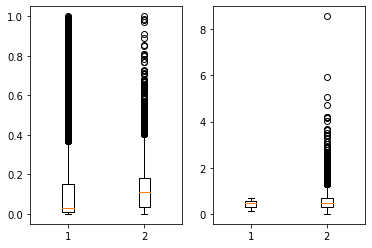

In [ ]:
# Let us remember the range of the target variables
plt.subplot(1, 2, 1)
plt.boxplot(y_train)
plt.subplot(1, 2, 2)
plt.boxplot(y_test)
plt.show()

In [ ]:
# == Q5 ==
# Diseña una RNN para resolver el problema de regresion multivariada que acabas de generar.
# Reporta el mejor resultado que hayas obtenido.

In [ ]:
# Your RNN Here
rnn_model = Sequential()
rnn_model.add(Input(shape=(x_train.shape[1], x_train.shape[2])))
rnn_model.add(LSTM(units=32))
rnn_model.add(Dense(16))
rnn_model.add(LeakyReLU())
rnn_model.add(Dense(2))

rnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32)                4608      
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16)                0         
                                                                 
 dense_2 (Dense)             (None, 2)                 34        
                                                                 
Total params: 5,170
Trainable params: 5,170
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Compile
rnn_model.compile(loss='mean_squared_error', optimizer='rmsprop')

In [ ]:
# Train
history = rnn_model.fit(x_train, y_train, epochs=30, batch_size=4, validation_split=0.1)

Epoch 1/30
2529/2529 [==============================] - 11s 4ms/step - loss: 0.0031 - val_loss: 0.0107
Epoch 2/30
2529/2529 [==============================] - 9s 4ms/step - loss: 0.0024 - val_loss: 0.0096
Epoch 3/30
2529/2529 [==============================] - 9s 4ms/step - loss: 0.0024 - val_loss: 0.0073
Epoch 4/30
2529/2529 [==============================] - 9s 4ms/step - loss: 0.0023 - val_loss: 0.0100
Epoch 5/30
2529/2529 [==============================] - 9s 4ms/step - loss: 0.0023 - val_loss: 0.0090
Epoch 6/30
2529/2529 [==============================] - 9s 3ms/step - loss: 0.0023 - val_loss: 0.0088
Epoch 7/30
2529/2529 [==============================] - 9s 4ms/step - loss: 0.0023 - val_loss: 0.0070
Epoch 8/30
2529/2529 [==============================] - 9s 3ms/step - loss: 0.0023 - val_loss: 0.0096
Epoch 9/30
2529/2529 [==============================] - 9s 4ms/step - loss: 0.0023 - val_loss: 0.0076
Epoch 10/30
2529/2529 [==============================] - 10s 4ms/step - loss: 0.0

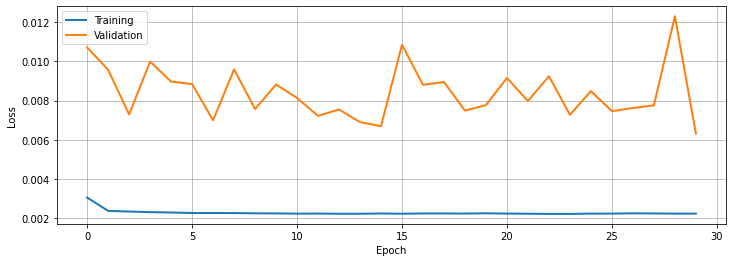

In [ ]:
# Plot loss
plt.figure(figsize=(12, 4))
plt.plot(history.history['loss'], label='Training', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [ ]:
# Predict on training and test sets
y_train_hat = rnn_model.predict(x_train)
y_test_hat = rnn_model.predict(x_test)
print(y_train_hat.shape)
print(y_test_hat.shape)

(11239, 2)
(2805, 2)


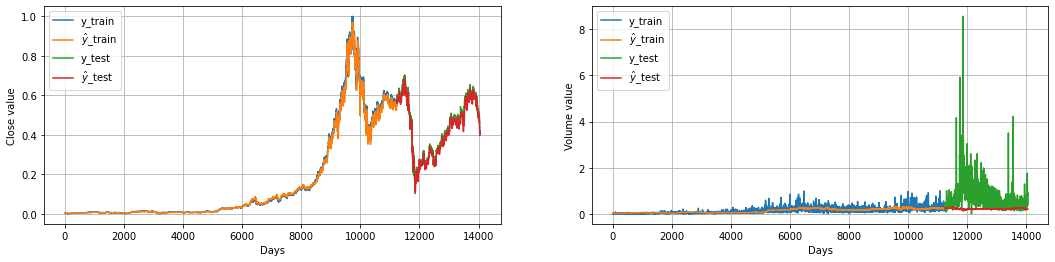

In [ ]:
# Plot y_train, y_train_hat, y_test and y_test_hat
x_ticks = np.arange(len(y_train) + len(y_test))

plt.figure(figsize=(18, 4))
plt.subplot(1, 2, 1)
plt.plot(x_ticks[:len(y_train)], y_train[:, 0])
plt.plot(x_ticks[:len(y_train)], y_train_hat[:, 0])
plt.plot(x_ticks[len(y_train):], y_test[:, 0])
plt.plot(x_ticks[len(y_train):], y_test_hat[:, 0])
plt.ylabel('Close value')
plt.xlabel('Days')
plt.legend(['y_train', '$\hat{y}$_train', 'y_test', '$\hat{y}$_test'], loc='upper left')
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(x_ticks[:len(y_train)], y_train[:, 1])
plt.plot(x_ticks[:len(y_train)], y_train_hat[:, 1])
plt.plot(x_ticks[len(y_train):], y_test[:, 1])
plt.plot(x_ticks[len(y_train):], y_test_hat[:, 1])
plt.ylabel('Volume value')
plt.xlabel('Days')
plt.legend(['y_train', '$\hat{y}$_train', 'y_test', '$\hat{y}$_test'], loc='upper left')
plt.grid()

plt.show()

In [ ]:
# == Q6 ==
# Parece que predecir 'close' es muy fácil, pero no predecir 'volume'.
# Explica las razones por las cuales crees que obtienes esos resultados.

In [ ]:
# == Q7 ==
# Ahora encuentra la forma de pasar columnas no consecutivas a la función "delayed_dataset".
# Crea sets donde,
# 'x' contenga (open, low, volume), e 'y' contenga (high, close)
# Considera delay=3 y history_size=4
x_train, y_train = delayed_dataset(np.vstack((train_data[:, 0], train_data[:, 2], train_data[:, 4])).T,
                                   np.vstack((train_data[:, 1], train_data[:, 3])).T, 3, 4)
x_test , y_test  = delayed_dataset(np.vstack((test_data[:, 0] , test_data[:, 2] , test_data[:, 4] )).T,
                                   np.vstack((test_data[:, 1] , test_data[:, 3] )).T, 3, 4)

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(11239, 4, 3)
(2805, 4, 3)
(11239, 2)
(2805, 2)


In [ ]:
# == Q8 ==
# Diseña una red para resolver este último problema de regresión.
# Reporta tu red con el mejor resultado.

In [ ]:
# Your RNN Here
rnn_model = Sequential()
rnn_model.add(Input(shape=(x_train.shape[1], x_train.shape[2])))

rnn_model.summary()

In [ ]:
# Compile
rnn_model.compile(loss='mean_squared_error', optimizer='rmsprop')

In [ ]:
# Train
history = rnn_model.fit(x_train, y_train, epochs=32, verbose=1, batch_size=4, validation_split=0.1)

Train on 10115 samples, validate on 1124 samples
Epoch 1/32
10115/10115 [==============================] - 6s 550us/sample - loss: 9.4784e-04 - val_loss: 0.0023
Epoch 2/32
10115/10115 [==============================] - 5s 491us/sample - loss: 2.6068e-04 - val_loss: 0.0018
Epoch 3/32
10115/10115 [==============================] - 5s 511us/sample - loss: 2.0293e-04 - val_loss: 6.3207e-04
Epoch 4/32
10115/10115 [==============================] - 5s 500us/sample - loss: 1.7300e-04 - val_loss: 2.9966e-04
Epoch 5/32
10115/10115 [==============================] - 5s 491us/sample - loss: 1.6557e-04 - val_loss: 3.8393e-04
Epoch 6/32
10115/10115 [==============================] - 5s 498us/sample - loss: 1.6049e-04 - val_loss: 3.9290e-04
Epoch 7/32
10115/10115 [==============================] - 5s 495us/sample - loss: 1.5399e-04 - val_loss: 3.6525e-04
Epoch 8/32
10115/10115 [==============================] - 5s 508us/sample - loss: 1.5379e-04 - val_loss: 6.6185e-04
Epoch 9/32
10115/10115 [=======

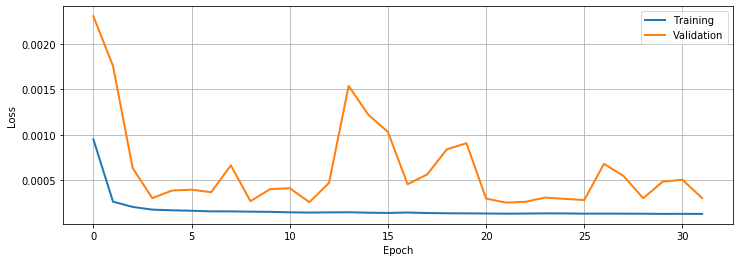

In [ ]:
# Plot loss
plt.figure(figsize=(12, 4))
plt.plot(history.history['loss'], label='Training', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [ ]:
# Predict on training and test sets
y_train_hat = rnn_model.predict(x_train)
y_test_hat = rnn_model.predict(x_test)
print(y_train_hat.shape)
print(y_test_hat.shape)

(11239, 2)
(2805, 2)


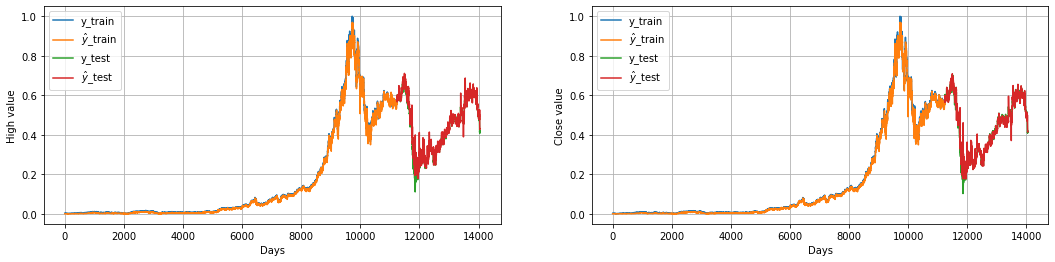

In [ ]:
# Plot y_train, y_train_hat, y_test and y_test_hat
x_ticks = np.arange(len(y_train) + len(y_test))

plt.figure(figsize=(18, 4))
plt.subplot(1, 2, 1)
plt.plot(x_ticks[:len(y_train)], y_train[:, 0])
plt.plot(x_ticks[:len(y_train)], y_train_hat[:, 0])
plt.plot(x_ticks[len(y_train):], y_test[:, 0])
plt.plot(x_ticks[len(y_train):], y_test_hat[:, 0])
plt.ylabel('High value')
plt.xlabel('Days')
plt.legend(['y_train', '$\hat{y}$_train', 'y_test', '$\hat{y}$_test'], loc='upper left')
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(x_ticks[:len(y_train)], y_train[:, 1])
plt.plot(x_ticks[:len(y_train)], y_train_hat[:, 1])
plt.plot(x_ticks[len(y_train):], y_test[:, 1])
plt.plot(x_ticks[len(y_train):], y_test_hat[:, 1])
plt.ylabel('Close value')
plt.xlabel('Days')
plt.legend(['y_train', '$\hat{y}$_train', 'y_test', '$\hat{y}$_test'], loc='upper left')
plt.grid()

plt.show()
# NOTA: las gráficas son muy parecidas, pero no iguales. -- El desempeño es bueno.